In [1]:
import os
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt

def clipped(im):
    h, w, _ = im.shape
    im = im[50:h-20, :w, :]
    return im

def extract_image(f):
    im = cv2.imread(f)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2YUV)
    #im = clipped(im)
    im = im[:,:,0:1]
    return im

def process_db(dir):
    with open(os.path.join(dir, 'driving_log.csv'), 'r') as f:
        data = pandas.read_csv(f, header=0, skipinitialspace=True)
        res = np.asarray(data.values)
        c, l, r, st, t, b, sp = np.split(res, 7, axis=1)
        l = np.array([extract_image(os.path.join(dir, p)) for p in l.squeeze()])
        c = np.array([extract_image(os.path.join(dir, p)) for p in c.squeeze()])
        r = np.array([extract_image(os.path.join(dir, p)) for p in r.squeeze()])        
        return l, c, r, st.squeeze().astype(np.float32)
        
l, c, r, st = process_db('./data')
print(c.shape)

(8036, 160, 320, 1)


(18, 160, 320, 1) (18,)


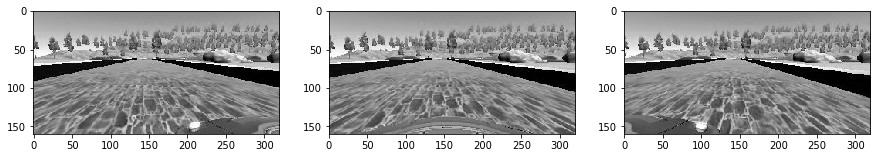

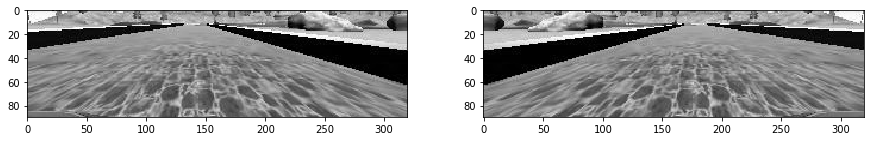

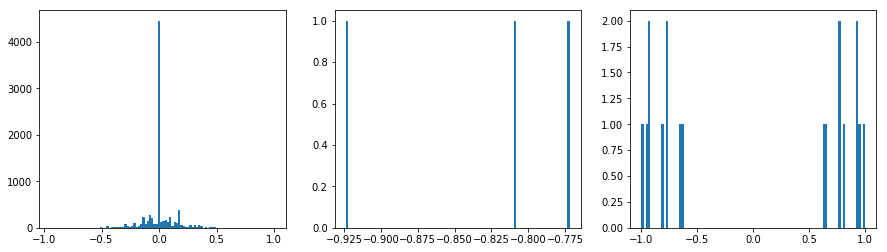

In [2]:
%matplotlib inline

def distribution(ar, bins=100):
    h, b = np.histogram(ar, bins)
    r = np.digitize(st, b)
    return r, np.bincount(r)

def old_balance_data(st, c, l, r, limit=0.10, nb_normal=500,nb_extreme=2000):
    extreme = np.logical_or(st<-limit, st>limit)
    normal = np.logical_and(st>=-limit, st<=limit)
    bal_st = np.append(st[normal][:nb_normal], st[extreme][:nb_extreme])
    bal_c = np.append(c[normal][:nb_normal], c[extreme][:nb_extreme], axis=0)
    bal_l = np.append(l[normal][:nb_normal], l[extreme][:nb_extreme], axis=0)
    bal_r = np.append(r[normal][:nb_normal], r[extreme][:nb_extreme], axis=0)
    return bal_st, bal_c, bal_l, bal_r

def old_balance_data(st, c, l, r, limit=0.10, nb_normal=500,nb_extreme=2000):
    extreme = np.logical_or(st<-limit, st>limit)
    normal = np.logical_and(st>=-limit, st<=limit)
    est, ec, el, er = st[extreme], c[extreme], l[extreme], r[extreme]
    nst, nc, nl, nr = st[normal], c[normal], l[normal], r[normal]
    
    bal_st = np.append(st[normal][:nb_normal], st[extreme][:nb_extreme])
    bal_c = np.append(c[normal][:nb_normal], c[extreme][:nb_extreme], axis=0)
    bal_l = np.append(l[normal][:nb_normal], l[extreme][:nb_extreme], axis=0)
    bal_r = np.append(r[normal][:nb_normal], r[extreme][:nb_extreme], axis=0)
    return bal_st, bal_c, bal_l, bal_r
    
def balance_data(st, c, l, r, n=10, bins=1000):
    dist, _ = distribution(st)
    bal_st = np.concatenate([st[dist==rng][:n] for rng in range(bins)])
    bal_c = np.concatenate([c[dist==rng][:n, :, :, :] for rng in range(bins)])
    bal_l = np.concatenate([l[dist==rng][:n, :, :, :] for rng in range(bins)])
    bal_r = np.concatenate([r[dist==rng][:n, :, :, :] for rng in range(bins)])
    return bal_st, bal_c, bal_l, bal_r

bal_st, bal_c, bal_l, bal_r = balance_data(st, c, l, r, 1, 10)
#bal_st, bal_c, bal_l, bal_r = old_balance_data(st, c, l, r, 0.05, 1000, 2000)

f = plt.figure(figsize=(15,4))
f.add_subplot(1,3,1).imshow(bal_l[-1].squeeze(), cmap='gray')
f.add_subplot(1,3,2).imshow(bal_c[-1].squeeze(), cmap='gray')
f.add_subplot(1,3,3).imshow(bal_r[-1].squeeze(), cmap='gray')

features = bal_c
labels = bal_st

features = np.append(features, bal_l, axis=0)
features = np.append(features, bal_r, axis=0)
labels = np.append(labels, bal_st+0.15, axis=0)
labels = np.append(labels, bal_st-0.15, axis=0)

flip = np.logical_or(labels<-0.5, labels>0.5)

f = plt.figure(figsize=(15,4))
f.add_subplot(1,2,1).imshow(clipped(features[-1]).squeeze(), cmap='gray')

features = np.append(features, [np.fliplr(f) for f in features[flip]], axis=0)
labels = np.append(labels, -labels[flip])

f.add_subplot(1,2,2).imshow(clipped(features[-1]).squeeze(), cmap='gray')

labels = np.clip(labels, -1., 1.)

f = plt.figure(figsize=(15,4))
_ = f.add_subplot(1,3,1).hist(st, 100)
_ = f.add_subplot(1,3,2).hist(bal_st, 100)
_ = f.add_subplot(1,3,3).hist(labels, 100)

print(features.shape, labels.shape)




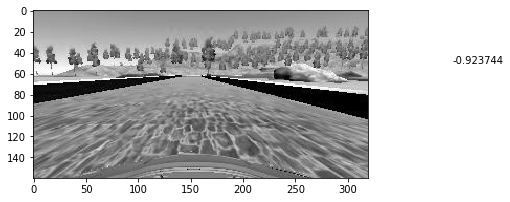

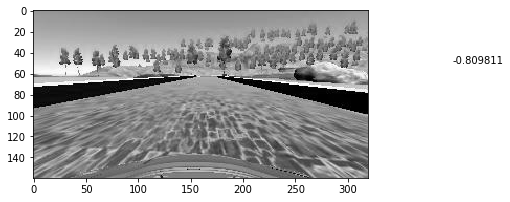

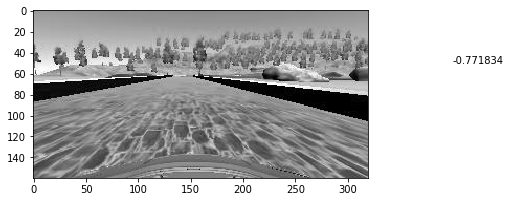

In [3]:
for i in range(len(bal_c)):
    plt.imshow(bal_c[i].squeeze(), cmap='gray')
    plt.text(400,50,str(bal_st[i]))
    plt.figure()

In [4]:
from sklearn.utils import shuffle

# labels = labels.astype(np.float32)
# features = features.astype(np.float32)

# mn = np.min(features, axis=(1,2,3), keepdims=True)
# mx = np.max(features, axis=(1,2,3), keepdims=True)
# rng = (mx - mn)
# features -= mn
# features = features/rng

X_train, y_train = shuffle(features, labels)
print(X_train.shape, y_train.shape)


(18, 160, 320, 1) (18,)


In [5]:
from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Dense, Activation, Flatten, Dropout, Lambda
from keras.layers.convolutional import Convolution2D
from keras.wrappers.scikit_learn import KerasRegressor

from keras.layers.pooling import MaxPooling2D
import numpy as np
from random import random

def my_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 1)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))
    model.add(Convolution2D(32, 5, 5, border_mode='same', activation='relu', name='c1'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64, 5, 5, border_mode='same', activation='relu', name='c2'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))    
    model.add(Convolution2D(128, 5, 5, border_mode='same', activation='relu', name='c3'))
    model.add(MaxPooling2D((2,2)))
    model.add(Dropout(0.5))    

    model.add(Flatten())
    model.add(Dense(512, activation='relu', name='d1'))
    model.add(Dense(64, activation='linear', name='d2'))
    model.add(Dense(16, activation='relu', name='d3'))
    model.add(Dense(1, activation='linear', name='out'))
    
    return model

def nvidia_model():
    model = Sequential()
    model.add(Cropping2D(cropping=((50,20), (0,0)), input_shape=(160, 320, 1)))
    model.add(Lambda(lambda x: (x / 255.0) - 0.5))    
    model.add(Convolution2D(24, 5, 5, border_mode='same', activation='relu', name='c1', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(36, 5, 5, border_mode='same', activation='relu', name='c2', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(48, 5, 5, border_mode='same', activation='relu', name='c3', subsample=(2,2)))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='c4'))
    model.add(Dropout(0.2))
    model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu', name='c5'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(1164, name='d1'))
    model.add(Dense(100, name='d2'))
    model.add(Dense(50, name='d3'))
    model.add(Dense(10, name='d4'))
    model.add(Dense(1, name='out'))

    return model


model = nvidia_model()
model.compile('adam', 'mse')
history = model.fit(X_train, y_train, batch_size=32, nb_epoch=3, verbose=2, validation_split=0.2)
y_pred = model.predict(X_train)

print(model.save("model.mine.h5"))


Using TensorFlow backend.


Train on 14 samples, validate on 4 samples
Epoch 1/3
2s - loss: 0.7745 - val_loss: 6.2642
Epoch 2/3
0s - loss: 9.4057 - val_loss: 0.3012
Epoch 3/3
0s - loss: 1.0189 - val_loss: 0.4404
None


[ 0.12387852] [ 0.21501607]


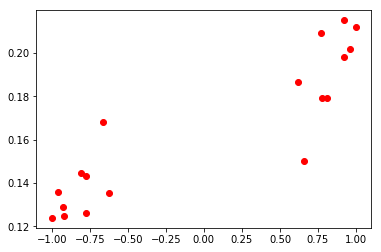

In [6]:
plt.plot(y_train, y_pred, 'ro')
print(np.min(y_pred, axis=0), np.max(y_pred, axis=0))


In [7]:
# balancing data
# different network model
# regularization
# all colour channels
# normalization it's own layer

# crop
# extrapolate
# visualize
